In [13]:
import os
import uproot
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import mplhep as hep

plt.rcParams.update({"figure.facecolor": (1,1,1,0)})

PLOTS_DIR = "/home/users/jguiang/public_html/lhe_plots/vbswh/"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [2]:
lumi_inv_fb = 138

sm_xsec_pb = 7.46969E-02
with uproot.open("../analysis/studies/lhe/output/sm_vbswh.root") as f:
    sm_df = f.get("tree").arrays(library="pd")
    sm_df["xsec_weight"] = (1000*sm_xsec_pb*lumi_inv_fb)/10000
    
mkw_xsec_pb = 4.32674E-01
with uproot.open("../analysis/studies/lhe/output/mkw_vbswh.root") as f:
    mkw_df = f.get("tree").arrays(library="pd")
    mkw_df["xsec_weight"] = (1000*mkw_xsec_pb*lumi_inv_fb)/10000

mkz_xsec_pb = 4.32675E-01
with uproot.open("../analysis/studies/lhe/output/mkz_vbswh.root") as f:
    mkz_df = f.get("tree").arrays(library="pd")
    mkz_df["xsec_weight"] = (1000*mkz_xsec_pb*lumi_inv_fb)/10000

In [3]:
sm_df

,H_pt,H_eta,H_phi,W_pt,W_eta,W_phi,W_sign,W_pol,M_WH,ld_VBS_pt,tr_VBS_pt,M_jj,deta_jj,xsec_weight
0,60.871685,-1.820305,0.913494,76.140106,-2.500283,1.785294,1.0,-1.0,255.570923,134.617065,14.726156,429.619385,-4.517941,1.030817
1,112.356201,2.148833,-1.678906,72.087090,2.778014,-1.379130,-1.0,0.0,223.680573,110.658501,71.993134,80.954948,0.874384,1.030817
2,35.484806,-3.257689,2.763932,75.865349,-3.424555,-1.620172,-1.0,-1.0,265.886719,112.489571,40.146591,268.492096,2.631935,1.030817
3,99.541206,0.007763,-2.982067,36.346718,2.677200,-0.155345,-1.0,1.0,342.409576,49.463070,17.217640,410.324707,-5.296206,1.030817
4,89.410530,1.761935,-0.785200,45.199257,3.479088,2.279681,-1.0,-1.0,310.877289,54.899921,31.849792,935.016296,6.212234,1.030817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,154.221817,-1.648610,0.687175,165.183716,1.709032,-1.836620,1.0,-1.0,905.221436,69.308784,33.915070,72.705902,1.248968,1.030817
9996,165.966248,2.262086,2.953602,82.207153,-1.010340,1.511744,1.0,1.0,647.475342,181.554596,49.121624,934.225098,4.586263,1.030817
9997,244.313553,0.369668,-3.136344,51.859146,2.615051,1.062024,1.0,-1.0,425.387726,173.810242,64.335136,635.129272,3.622746,1.030817
9998,130.862732,0.924803,0.439256,57.005123,-1.800603,-2.990807,-1.0,1.0,414.600037,43.071594,41.987694,404.588989,4.520261,1.030817


In [4]:
mkw_df

,H_pt,H_eta,H_phi,W_pt,W_eta,W_phi,W_sign,W_pol,M_WH,ld_VBS_pt,tr_VBS_pt,M_jj,deta_jj,xsec_weight
0,544.724243,0.592779,0.308183,424.565063,-1.409708,-2.946017,1.0,0.0,1500.937500,115.970482,16.176542,1572.864136,7.185885,5.970901
1,828.864807,0.267278,0.397106,674.447510,0.455236,-2.985035,-1.0,0.0,1505.593628,124.248451,116.666222,1112.830688,-4.469151,5.970901
2,110.362495,-0.558760,-1.310278,367.720337,-0.816316,1.439844,1.0,0.0,483.646912,217.904785,95.681953,2387.578857,5.613726,5.970901
3,391.880188,-1.492256,-2.695978,474.956146,-0.741614,0.300894,-1.0,0.0,944.836731,105.336746,23.297476,983.572083,-5.975994,5.970901
4,377.690338,-0.269097,-1.514508,136.434692,0.316989,0.952049,1.0,0.0,496.667480,278.243256,12.909877,90.049683,-1.028383,5.970901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,617.050415,-0.338841,1.436326,702.245667,0.326343,-1.699504,1.0,0.0,1406.275757,61.412006,25.581203,1066.828735,6.587924,5.970901
9996,991.442078,-0.108761,-2.325187,929.206299,-0.224181,0.778199,1.0,0.0,1933.837891,57.059345,26.886787,1064.337402,6.605580,5.970901
9997,350.911377,-1.599062,-0.116096,442.762268,1.447295,-2.948031,1.0,0.0,1901.901245,172.667648,28.608690,1296.696045,-5.825641,5.970901
9998,102.840721,-0.113239,-0.090554,92.572884,-0.004578,2.166976,-1.0,0.0,271.948059,79.453537,32.737602,722.827271,5.302024,5.970901


In [5]:
mkz_df

,H_pt,H_eta,H_phi,W_pt,W_eta,W_phi,W_sign,W_pol,M_WH,ld_VBS_pt,tr_VBS_pt,M_jj,deta_jj,xsec_weight
0,544.724243,0.592779,0.308183,424.565063,-1.409708,-2.946017,1.0,0.0,1500.937500,115.970482,16.176542,1572.864136,7.185885,5.970915
1,840.608582,-0.809868,-2.954451,928.451538,1.057360,0.177269,1.0,0.0,2603.644287,52.609993,47.813370,2016.745483,7.388942,5.970915
2,192.260529,0.359841,-0.556774,417.262024,-0.170720,2.788278,-1.0,0.0,629.418762,257.918671,52.277020,1074.883179,4.437245,5.970915
3,189.880737,-0.034341,0.618054,428.950928,1.066529,3.090861,-1.0,0.0,690.049072,271.905975,122.795143,1769.578247,-4.541939,5.970915
4,1307.744507,-0.573304,1.679916,1136.515747,0.030637,-1.546649,-1.0,0.0,2556.474365,176.039703,25.051119,905.479126,5.235497,5.970915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,50.016994,-1.234357,2.221553,83.762375,-1.282884,0.247465,1.0,0.0,245.020218,52.167496,34.640396,81.816772,-1.562750,5.970915
9996,462.326141,0.254762,-2.118835,328.497803,0.294674,1.160951,-1.0,0.0,804.456543,97.577545,68.473518,1211.067627,5.395887,5.970915
9997,48.170959,-2.409391,2.293627,44.368492,1.387738,0.687967,1.0,0.0,374.670166,45.533154,36.794540,1040.539429,-6.471855,5.970915
9998,146.781097,0.135987,1.972869,123.647179,-0.954495,-2.918646,-1.0,0.0,314.773376,150.658554,66.985970,1639.045044,-5.590205,5.970915


In [14]:
plt.style.use(hep.style.CMS)

def smart_clip(np_array, bins):
    if len(bins) < 2:
        raise ValueError("must have at least two bins")
        return
    clip_low = 0.5 * (bins[0] + bins[1])
    clip_high = 0.5 * (bins[-2] + bins[-1])
    return np.clip(np_array, clip_low, clip_high)

def plot(var, bins=None, query="index >= 0", x_label="", transf=lambda x: x, 
         logy=False, show_events=False, norm=False, outfile=None):
    
    fig, axes = plt.subplots()

    if norm:
        show_events = False

    # Plot SM
    global sm_df
    sm_weights = sm_df.query(query).xsec_weight
    if norm:
        sm_weights *= 1/np.sum(sm_weights)
    axes.hist(
        smart_clip(transf(sm_df.query(query)[var]), bins), 
        bins=bins,
        label=(f"SM [{np.sum(sm_weights):0.1f} events]" if show_events else "SM"),
        alpha=0.5,
        weights=sm_weights,
        log=logy
    );
    
    # Plot -kW
    global mkw_df
    mkw_weights = mkw_df.query(query).xsec_weight
    if norm:
        mkw_weights *= 1/np.sum(mkw_weights)
    axes.hist(
        smart_clip(transf(mkw_df.query(query)[var]), bins), 
        bins=bins, 
        histtype="step",
        label=(f"$\kappa_W = -1$ [{np.sum(mkw_weights):0.1f} events]" if show_events else "$\kappa_W = -1$"),
        weights=mkw_weights,
        log=logy
    );
    
    # Plot -kZ
    global mkz_df
    mkz_weights = mkz_df.query(query).xsec_weight
    if norm:
        mkz_weights *= 1/np.sum(mkz_weights)
    axes.hist(
        smart_clip(transf(mkz_df.query(query)[var]), bins), 
        bins=bins, 
        histtype="step",
        label=(f"$\kappa_Z = -1$ [{np.sum(mkz_weights):0.1f} events]" if show_events else "$\kappa_Z = -1$"),
        weights=mkz_weights,
        log=logy
    );
    
    # Plot legend
    axes.legend();
    # Change axis labels
    axes.set_xlabel(x_label);
    axes.set_ylabel("a.u." if norm else "Events");
    # Add CMS label
    hep.cms.label(
        "Preliminary",
        data=False,
        lumi=138,
        loc=0,
        ax=axes,
    )
    
    if outfile:
        plt.savefig(outfile)
    
    return axes

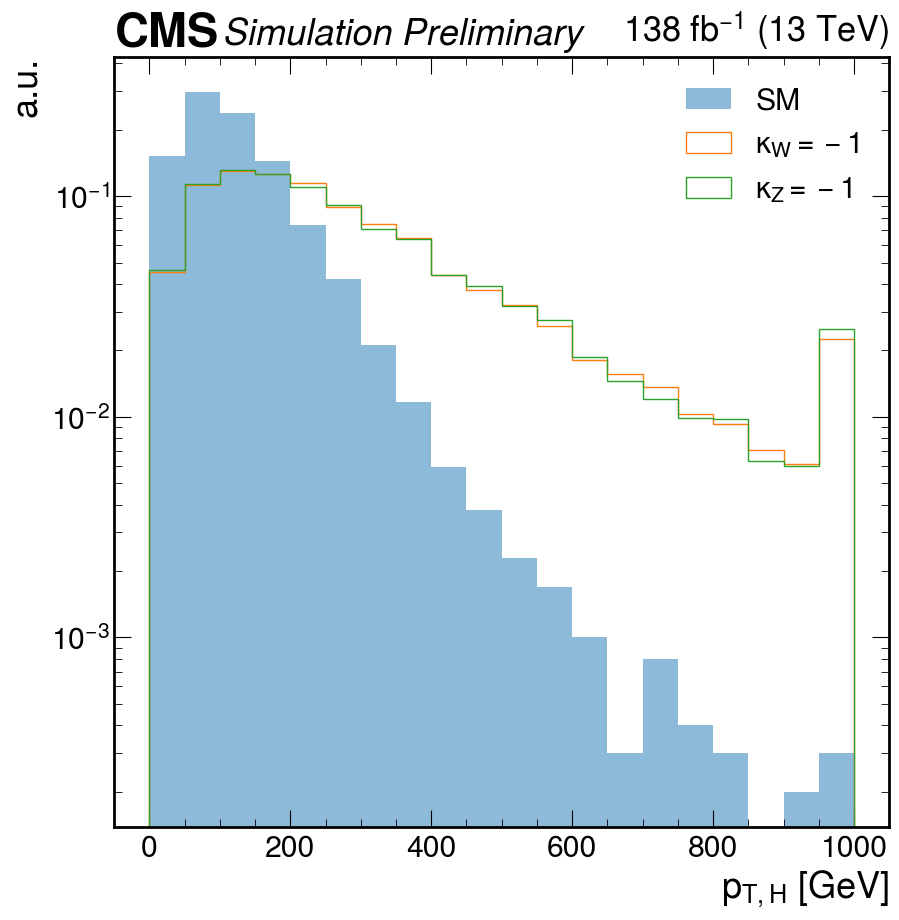

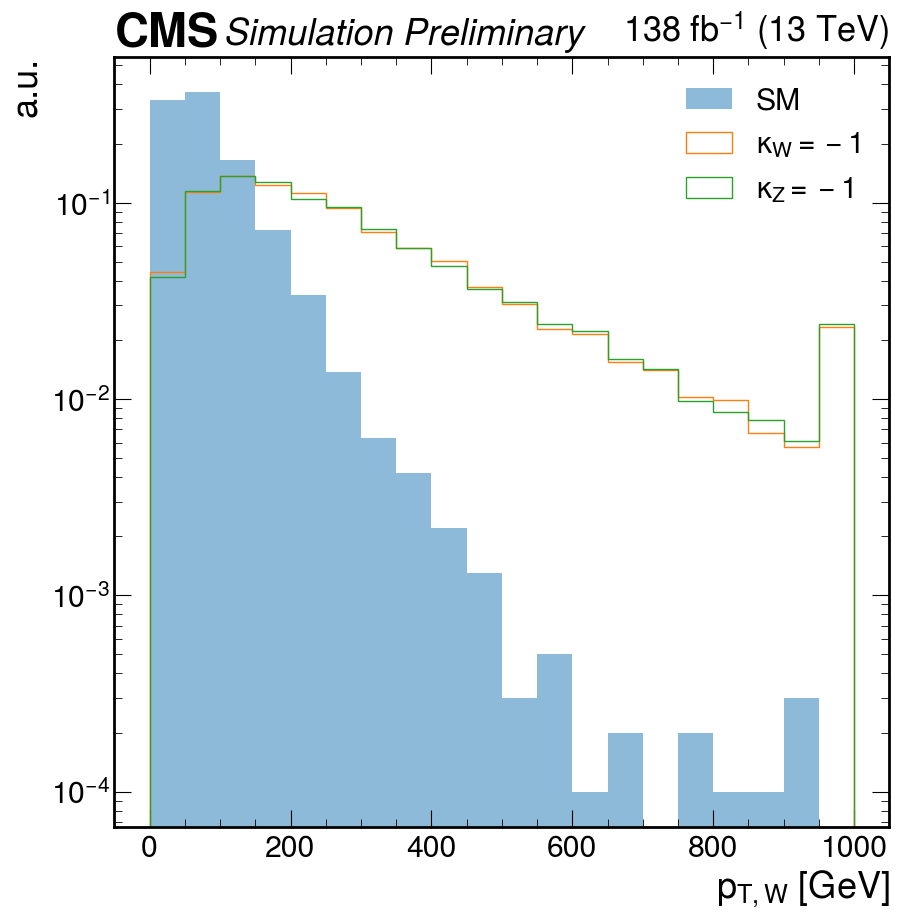

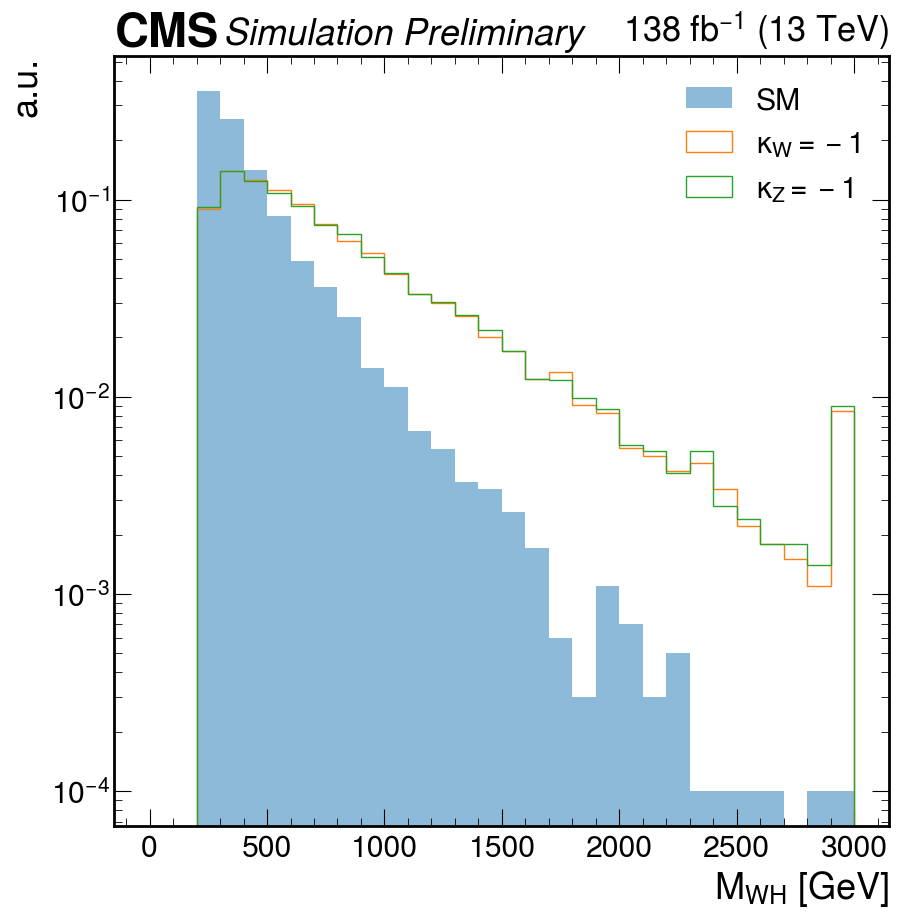

In [18]:
plot("H_pt", bins=np.linspace(0, 1000, 21), x_label="$p_{T,H}$ [GeV]", logy=True, norm=True, outfile=f"{PLOTS_DIR}/lhe_H_pt.pdf");
plot("W_pt", bins=np.linspace(0, 1000, 21), x_label="$p_{T,W}$ [GeV]", logy=True, norm=True, outfile=f"{PLOTS_DIR}/lhe_W_pt.pdf");
plot("M_WH", bins=np.linspace(0, 3000, 31), x_label="$M_{WH}$ [GeV]", logy=True, norm=True, outfile=f"{PLOTS_DIR}/lhe_M_WH.pdf");

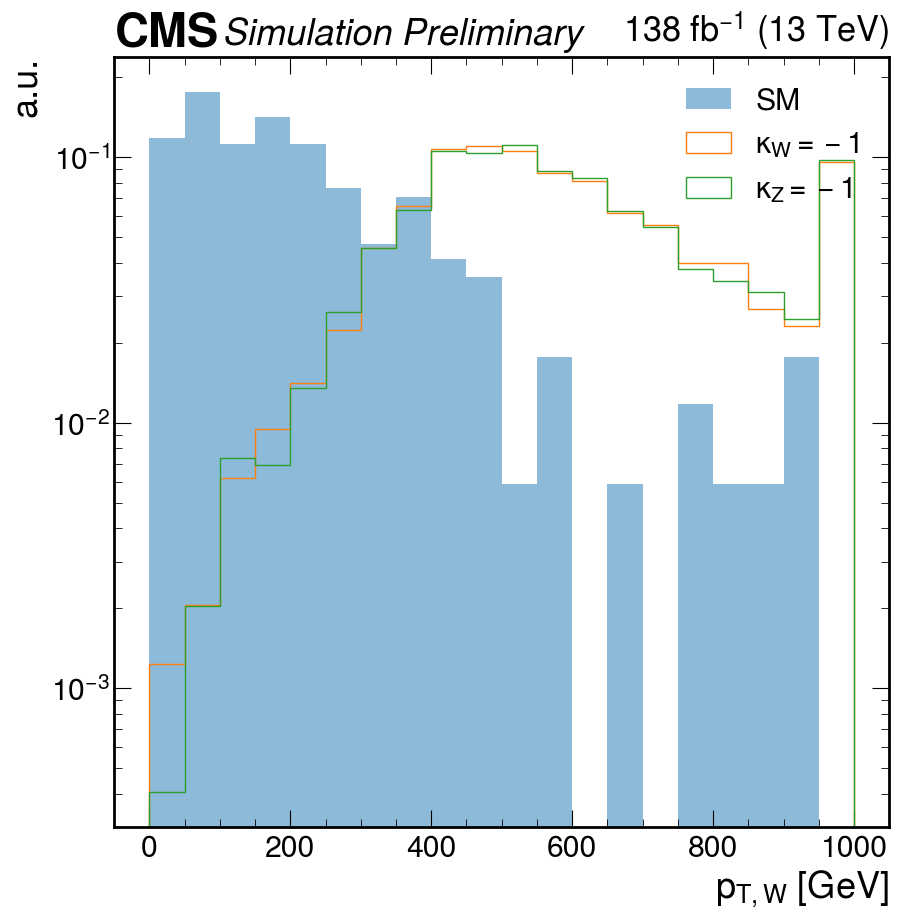

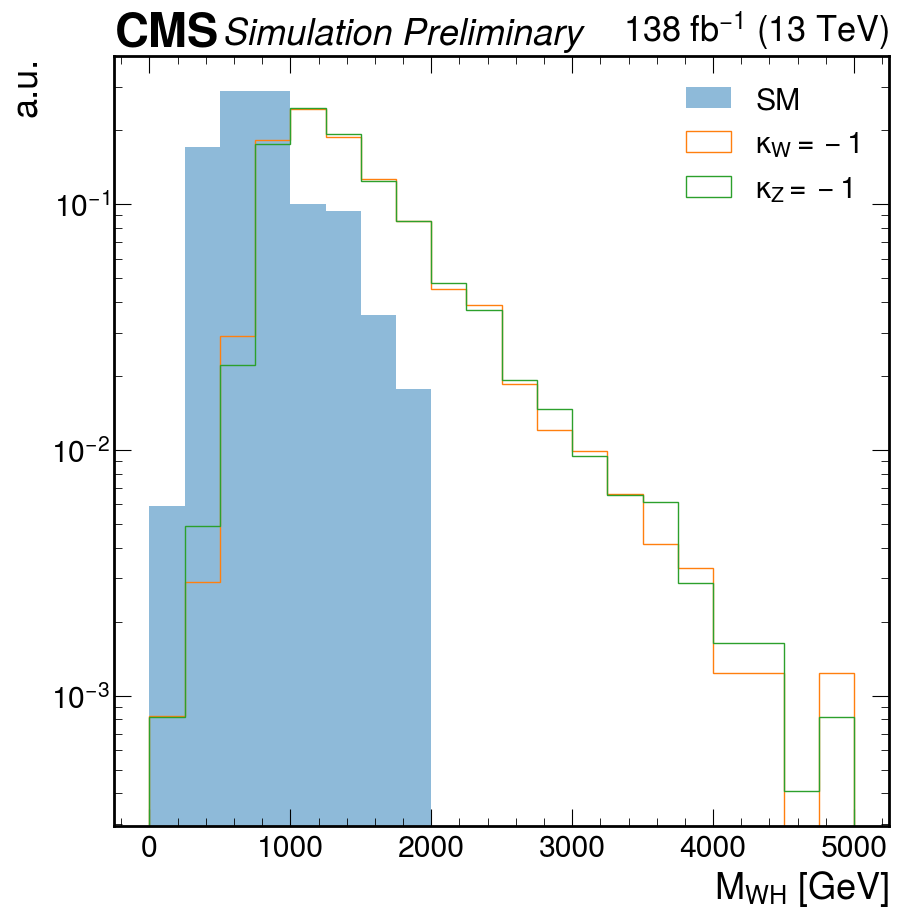

In [8]:
plot("W_pt", bins=np.linspace(0, 1000, 21), query="H_pt > 400", x_label="$p_{T,W}$ [GeV]", logy=True, norm=True);
plot("M_WH", bins=np.linspace(0, 5000, 21), query="H_pt > 400", x_label="$M_{WH}$ [GeV]", logy=True, norm=True);

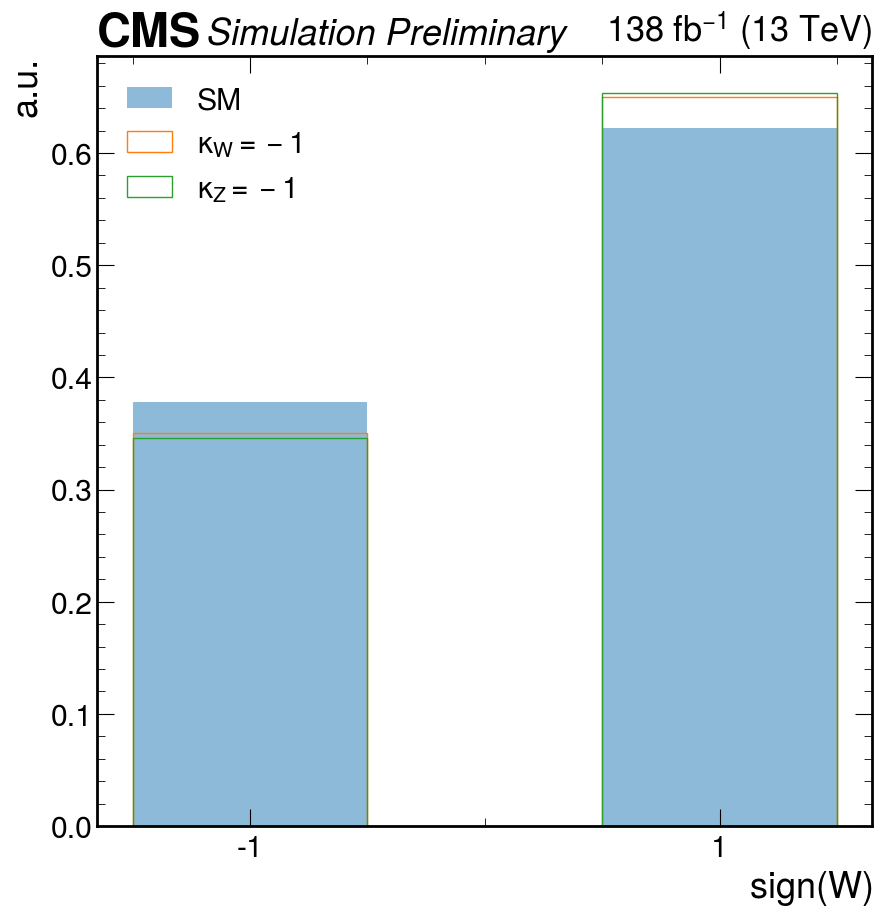

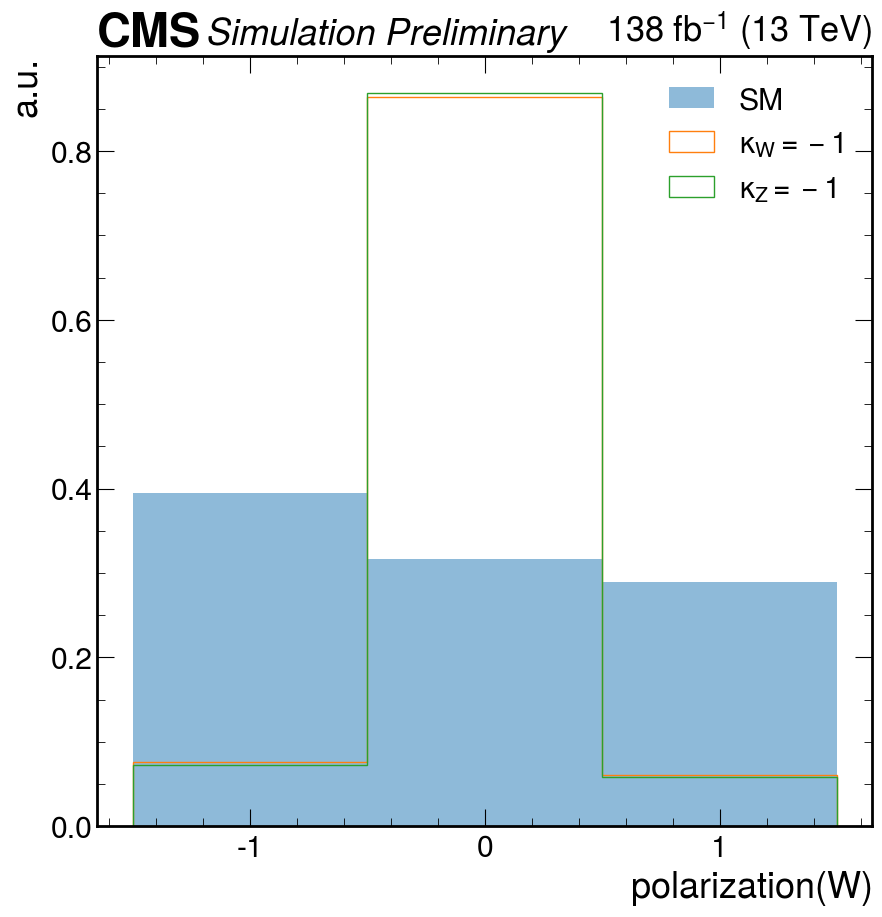

In [20]:
axes = plot("W_sign", bins=[-1, 0, 1, 2], x_label="$sign(W)$", transf=np.sign, norm=True)
axes.set_xticks([-0.5, 1.5]);
axes.set_xticklabels([-1, 1]);

axes = plot("W_pol", bins=[-1, 0, 1, 2], x_label="$polarization(W)$", transf=np.sign, norm=True)
axes.set_xticks([-0.5, 0.5, 1.5]);
axes.set_xticklabels([-1, 0, 1]);

<AxesSubplot:xlabel='$M_{jj}$ [GeV]', ylabel='a.u.'>

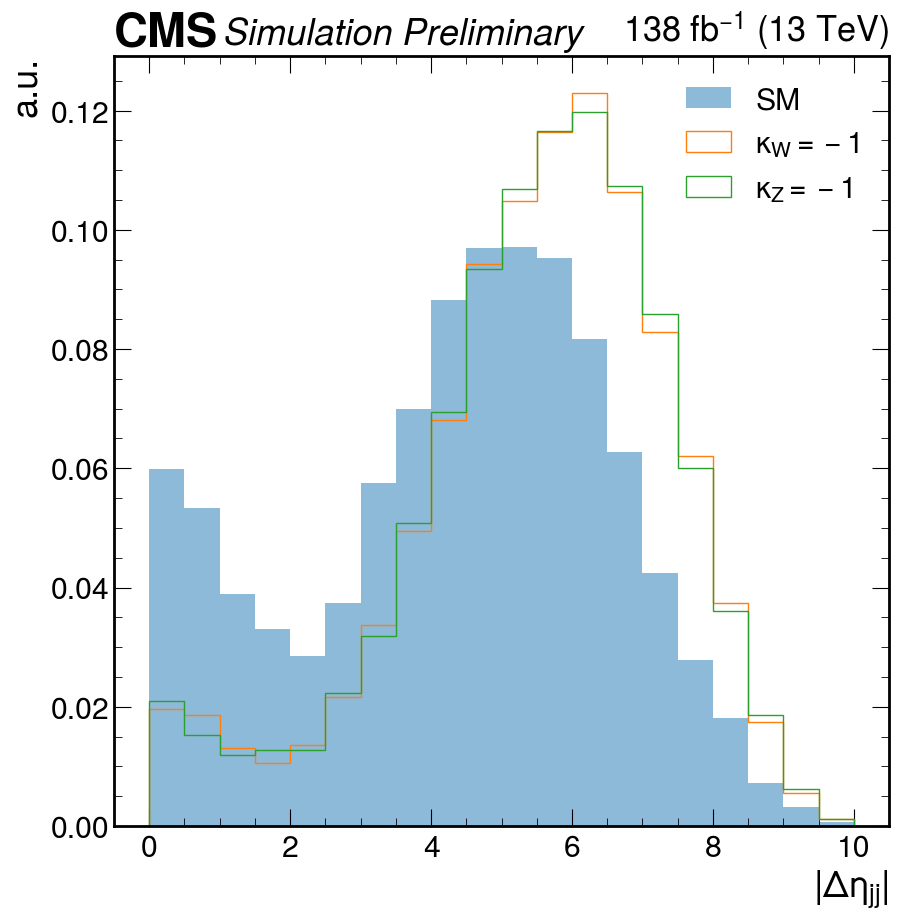

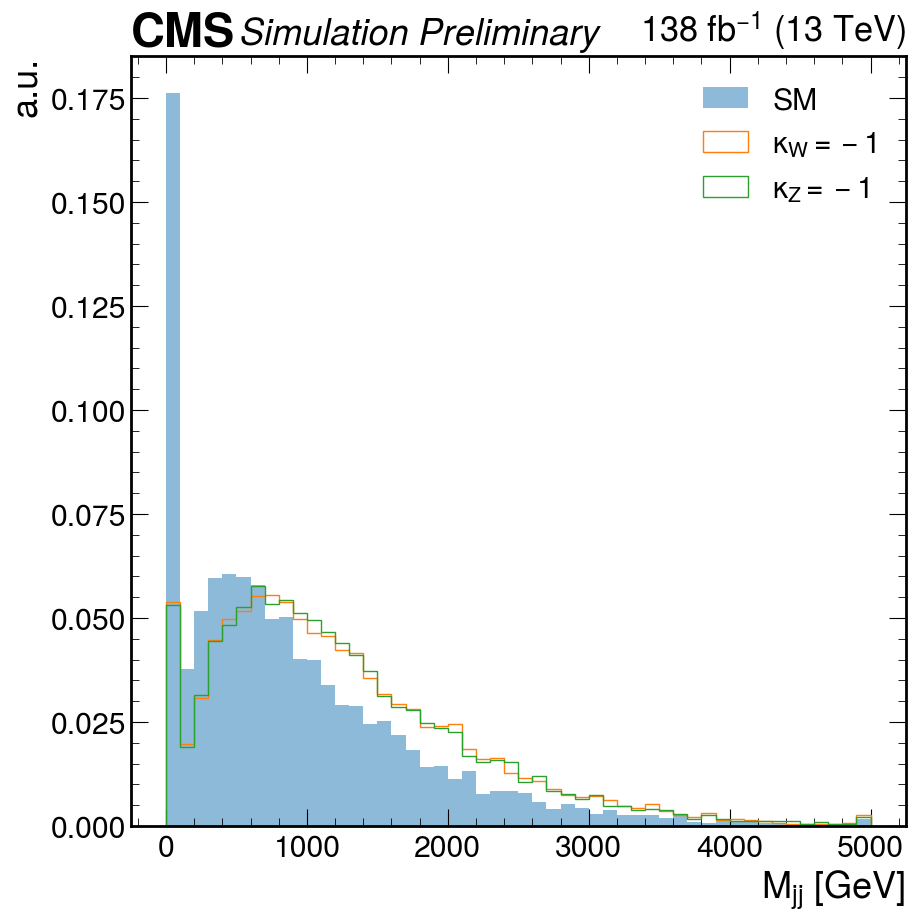

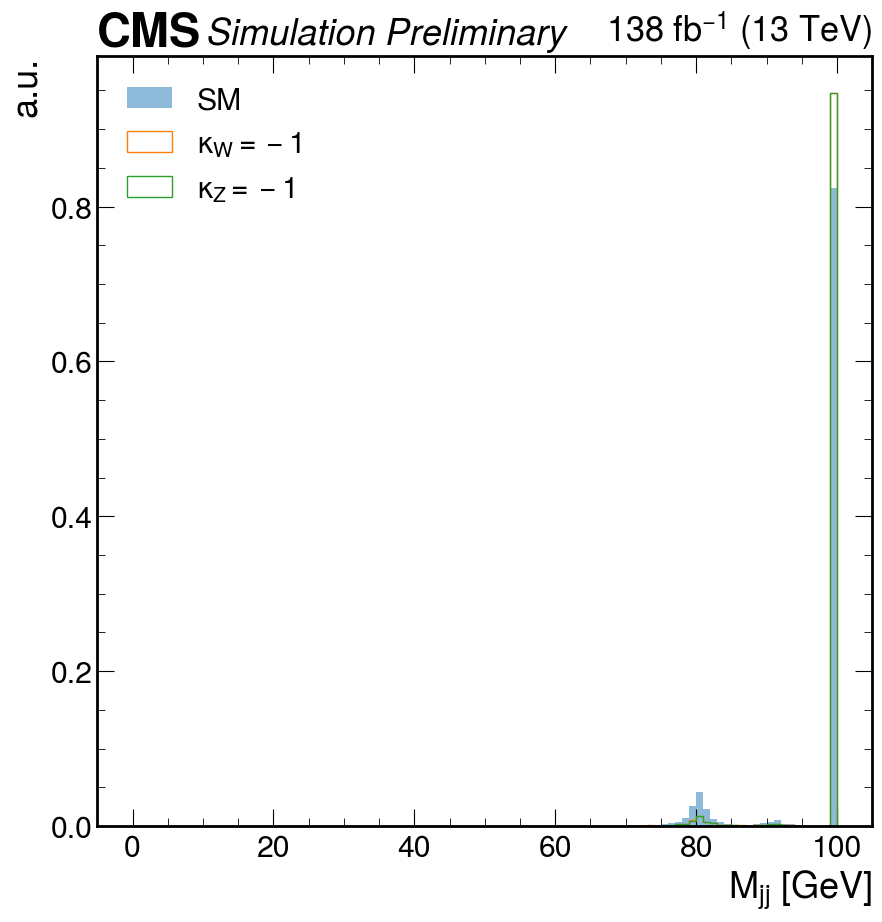

In [21]:
plot("deta_jj", bins=np.linspace(0, 10, 21), x_label="$|\Delta\eta_{jj}|$", transf=np.abs, norm=True);
plot("M_jj", bins=np.linspace(0, 5000, 51), x_label="$M_{jj}$ [GeV]", norm=True);
plot("M_jj", bins=np.linspace(0, 100, 101), x_label="$M_{jj}$ [GeV]", norm=True)

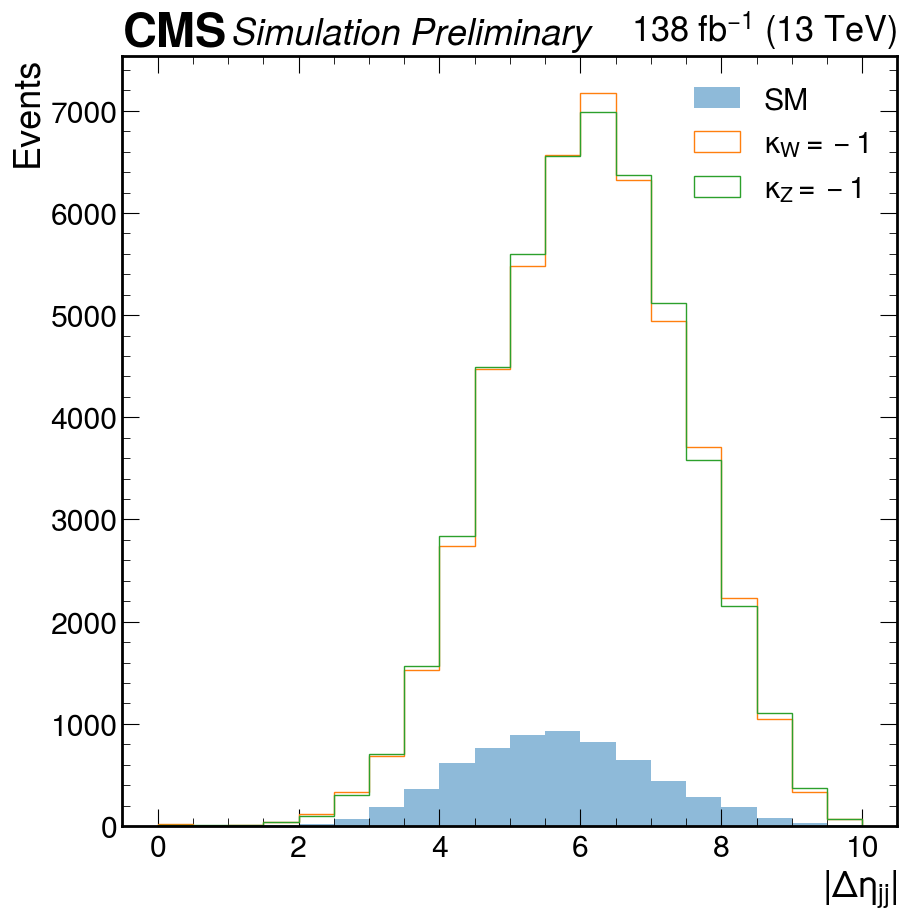

In [11]:
plot("deta_jj", bins=np.linspace(0, 10, 21), query="M_jj > 500", x_label="$|\Delta\eta_{jj}|$", transf=np.abs);